<a href="https://colab.research.google.com/github/EmeraldMath/Tensorflow_models/blob/master/tf_keras_regression_model_wide_and_deep_multi_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

TensorFlow 2.x selected.
2.1.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.5
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7) #default test_size = 0.25
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# multi-input and functional API
#decide the first 5 features as inputs for wide model, and the last 6 features as inputs for deep model
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
output2 = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs = [input_wide, input_deep],
                          outputs = [output, output2])

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta = 1e-2)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [6]:
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]

history = model.fit([x_train_scaled_wide, x_train_scaled_deep],
                    [y_train, y_train],
                    validation_data = (
                        [x_valid_scaled_wide, x_valid_scaled_deep],
                        [y_valid, y_valid]),
                    epochs = 100,
                    callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 167us/sample - loss: 3.7187 - dense_2_loss: 1.8971 - dense_3_loss: 1.8205 - val_loss: 1.7007 - val_dense_2_loss: 0.7965 - val_dense_3_loss: 0.9041
Epoch 2/100
11610/11610 [==============================] - 1s 85us/sample - loss: 1.2671 - dense_2_loss: 0.5887 - dense_3_loss: 0.6783 - val_loss: 1.1450 - val_dense_2_loss: 0.5207 - val_dense_3_loss: 0.6241
Epoch 3/100
11610/11610 [==============================] - 1s 84us/sample - loss: 1.0326 - dense_2_loss: 0.4622 - dense_3_loss: 0.5703 - val_loss: 1.0407 - val_dense_2_loss: 0.4585 - val_dense_3_loss: 0.5820
Epoch 4/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.9486 - dense_2_loss: 0.4222 - dense_3_loss: 0.5264 - val_loss: 0.9523 - val_dense_2_loss: 0.4265 - val_dense_3_loss: 0.5256
Epoch 5/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.8897 - dense_2_loss: 0.3975 - dens

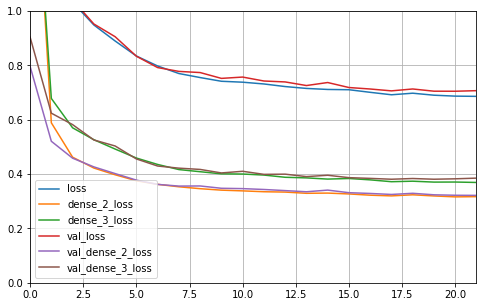

In [7]:
def plot_learning_curves(history):
  pd.DataFrame(history.history).plot(figsize = (8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()
plot_learning_curves(history)

In [8]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep], [y_test, y_test])

5160/5160 [==============================] - 0s 37us/sample - loss: 0.7286 - dense_2_loss: 0.3314 - dense_3_loss: 0.3991


[0.7286219612572544, 0.33143732, 0.39906034]

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir callbacks